In [1]:
# import modules
%matplotlib inline
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet, BatchIterator
from sklearn.cross_validation import train_test_split

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


(800, 1280, 3)


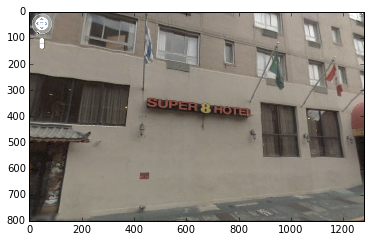

In [57]:
# test image
from scipy.misc import imread as ims
img = ims('/home/faizy/workspace/project/project/datasets/svt/svt1/img/01_15.jpg')#img -> 00_12[292:450, 176:850, :]
print img.shape
# image[y:y + image_height, x:x + image_width, :]
pylab.imshow(img)
pylab.show()

In [3]:
# extra functions
def unpickle(filer):
    f = open(filer, 'rb')
    d_dict = pkl.load(f)
    f.close()
    return d_dict

In [4]:
def shiftup(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        # loop for shift up
        for j in range(16):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, 16 + j : 16 + j + 1, :]
        for j in range(16, 32):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 15, :]
    return shifted_dataset

In [5]:
def shiftdown(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        # loop for shift up
        for j in range(16, 32):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, j - 16 : j + 1 - 16, :]
        for j in range(16):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 16, :]
    return shifted_dataset

In [6]:
def shiftleft(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(16):
            shifted_dataset[i, 0, :, j:j+1] = dataset[i, 0, :, 16 + j: 16 + j + 1]
        for j in range(16, 32):
            shifted_dataset[i, :, :, j] = shifted_dataset[i, :, :, 15]
    
    return shifted_dataset

In [7]:
def shiftright(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(16, 32):
            shifted_dataset[i, 0, :, j : j + 1] = dataset[i, 0, :, j - 16 : j + 1 - 16]
        for j in range(16):
            shifted_dataset[i, 0, :, j] = dataset[i, 0, :, 15]
    
    return shifted_dataset

In [8]:
# load train_test set
# cifar
train_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/data_batch_1')
train2_images = train_dict['data'].astype('float32')
train2_y = np.zeros((10000, )).astype('int')
test_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/test_batch')
test2_images = test_dict['data'].astype('float32')

# chars74k
data = pd.read_csv('/home/faizy/workspace/project/project/scripts/LISTFILE.txt', sep = ' ', header = None)
root = '/home/faizy/workspace/project/project/datasets/English/'
data_x = np.zeros((data.shape[0], 1, 32, 32))
data_y = np.ones((data.shape[0], )).astype('int32')
from scipy.misc import imread, imresize
for idx, path in enumerate(data[0]):
    img = imread(root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [9]:
# Augmented data
train3_x = shiftup(train1_x)
train4_x = shiftdown(train1_x)
train5_x = shiftleft(train1_x)
train6_x = shiftright(train1_x)

train3_y = np.zeros((train3_x.shape[0], )).astype('int')
train4_y = np.zeros((train4_x.shape[0], )).astype('int')
train5_y = np.zeros((train5_x.shape[0], )).astype('int')
train6_y = np.zeros((train6_x.shape[0], )).astype('int')

In [10]:
print train1_x.shape, train2_images.shape, train3_x.shape, train4_x.shape, train5_x.shape, train6_x.shape

(6164, 1, 32, 32) (10000, 3072) (6164, 1, 32, 32) (6164, 1, 32, 32) (6164, 1, 32, 32) (6164, 1, 32, 32)


In [11]:
# preprocess
# cifar
train2_images /= train2_images.std(axis = None)
train2_images -= train2_images.mean()

test2_images /= test2_images.std(axis = None)
test2_images -= test2_images.mean()

# chars74k
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

# augmented data

train3_x /= train3_x.std(axis = None)
train3_x -= train3_x.mean()

train4_x /= train4_x.std(axis = None)
train4_x -= train4_x.mean()

train5_x /= train5_x.std(axis = None)
train5_x -= train5_x.mean()

train6_x /= train6_x.std(axis = None)
train6_x -= train6_x.mean()

In [12]:
# reshape dataset
# cifar
# grayscaling and cropping to size
train2_x_rgb = train2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    train2_x[i, :, :, :] = np.dot(train2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

test2_x_rgb = test2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

test2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    test2_x[i, :, :, :] = np.dot(test2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

In [13]:
# finally
train_x = np.vstack((train1_x, train2_x))
train_x = np.vstack((train_x, train3_x))
train_x = np.vstack((train_x, train4_x))
train_x = np.vstack((train_x, train5_x))
train_x = np.vstack((train_x, train6_x))

train_y = np.concatenate([train1_y, train2_y, train3_y, train4_y, train5_y, train6_y])

test_x = np.vstack((test1_x, test2_x))

test_y = np.concatenate([test1_y, np.zeros((10000,))])

In [14]:
# check again
train_x = train_x.astype('float32')
train_y = train_y.astype('int32')
test_x = test_x.astype('float32')
test_y = test_y.astype('int32')

In [16]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (5, 5),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (5, 5),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    conv3_num_filters = 128, conv3_filter_size = (5, 5),
    hidden4_num_units = 128,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update=nesterov_momentum,
    update_learning_rate = 0.01,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 50,
    verbose = 1,
)

In [17]:
# train and test nn
net.fit(train_x, train_y)
pred = net.predict(test_x)

# Neural Network with 273794 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x28x28
  2  pool1     32x14x14
  3  dropout1  32x14x14
  4  conv2     64x10x10
  5  pool2     64x5x5
  6  dropout2  64x5x5
  7  conv3     128x1x1
  8  hidden4   128
  9  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.41914       1.12840      0.37144      0.86300  31.55s
      2       0.73000       0.40084      1.82116      0.86300  31.76s
      3       0.44202       0.40054      1.10356      0.86300  31.45s
      4       0.45359       0.40098      1.13120      0.86300  31.45s
      5       0.45487       0.40079      1.13493      0.86300  31.38s
      6       0.45314       0.40069      1.13090      0.86300  31.37s
      7       0.45193       0.40061      1.12809      0.86300  31.45s
      8       0.45099       0.400

In [18]:
f = open('/home/faizy/workspace/project/project/models/detector_1.pkl', 'wb')
pkl.dump(net, f)
f.close()

In [19]:
from sklearn.metrics import accuracy_score, classification_report
print classification_report(test_y, pred)

             precision    recall  f1-score   support

          0       0.91      0.99      0.95     10000
          1       0.87      0.35      0.50      1541

avg / total       0.90      0.91      0.89     11541



In [66]:
from sklearn.feature_extraction import image
patches = image.extract_patches(img, (100, 50, 3), extraction_step = 5)
print patches.shape

(141, 247, 1, 100, 50, 3)


In [67]:
from scipy.misc import imresize
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, 0, :, :, :], (32, 32)))
        
print len(new_lst)

34827


In [68]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32)

In [69]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [70]:
print tester.shape

(34827, 1, 32, 32)


In [74]:
preder = net.predict_proba(tester)

In [77]:
heatmap = preder[:, 1].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(141, 247)


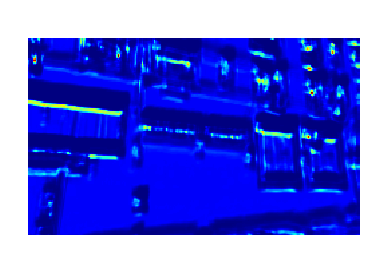

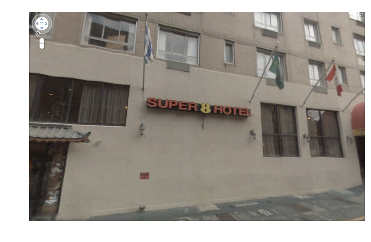

In [78]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [54]:
preder.shape

(22940,)